## Commodity Data Exploration and Analysis

In this file I will perform some data exploration and analysis of the commodity data

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

commodity_set = pd.read_csv('Z:\\Asus Documents\\PythonProgramming\\mdBest\\commodity_list.csv', header=None)
county_set = pd.read_csv('Z:\\Asus Documents\\PythonProgramming\\mdBest\\counties.csv', header=None)
population_set = pd.read_csv('Z:\\Asus Documents\\PythonProgramming\\mdBest\\maryland_population.csv', header=0)

### Location/County Data

In [96]:
# Clean up the county set
county_set = county_set.drop(columns=[0,1])
county_set = county_set.drop([0])
county_set = county_set.rename(columns={2:'Address', 3: 'Coordinates', 4: 'Jurisdiction'})

In [97]:
county_set.groupby('Jurisdiction').size()

Jurisdiction
Allegany County            4
Anne Arundel County       19
Baltimore City            22
Baltimore County          42
Calvert County            11
Caroline County            8
Carroll County            26
Cecil County              10
Charles County             8
Dorchester County          5
Frederick County          30
Garrett County             7
Harford County            19
Howard County             13
Kent County                6
Montgomery County         32
New Castle County          1
Prince George's County    24
Queen Anne's County       14
Somerset County            2
St. Mary's County          6
Talbot County              7
Washington County         17
Wicomico County            8
Worcester County           6
dtype: int64

Interestingly, a single Delaware entry was included- from New Castle County. There are at least two records from every Maryland jurisdiction though.

In [98]:
county_set[(county_set['Jurisdiction'] == 'New Castle County')]

,Address,Coordinates,Jurisdiction
34,"Rt 40 & 896, Bear, DE \n","39.6056676, -75.74132559999998",New Castle County


In [99]:
commodity_set.groupby(commodity_set.iloc[34,:]).size()

34
35            1
Vegetables    1
dtype: int64

Because the record is not in the target group, and also because it does not contain commodity data that is very useful- only "Vegetables" is listed as a commodity- the Delaware record will be removed.

In [100]:
county_set = county_set.drop(county_set.index[[34]])
commodity_set = commodity_set.drop(commodity_set.index[[34]])

In [101]:
county_group = county_set.groupby('Jurisdiction', as_index=False).size()

<AxesSubplot:xlabel='Jurisdiction'>

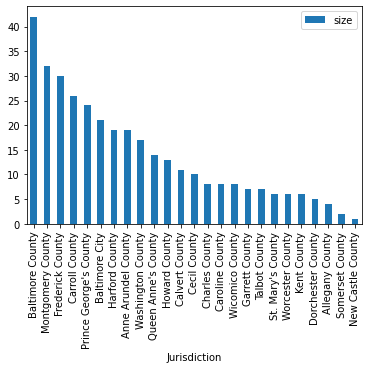

In [102]:
county_group.sort_values('size',ascending = False).plot(kind = 'bar', x = 0, y = 1)

#### Commodity Records by Jurisdiction

Just by the distribution of records by county there appears to be a variation based on population, but the spread of commodity records appears to have a more even spread than that of the State's population. Population per county data from the [Maryland Department of Planning](https://planning.maryland.gov/MSDC/Pages/pop_estimate/popest_cnty.aspx) is shown below.

In [103]:
population_set = population_set.rename(columns={' State/Jurisdiction ': 'State/Jurisdiction'})

<AxesSubplot:xlabel='State/Jurisdiction'>

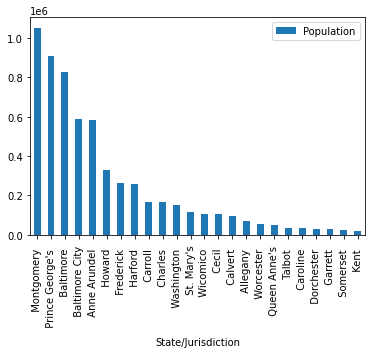

In [104]:
population_set.sort_values(by = 'Population', ascending = False).plot(kind = 'bar', x = 0, y = 1)

#### Population by Jurisdiction

Below, the connection between population and the number of commodity records is explored using variance analysis.

In [105]:
# Match the jurisdiction names
population_set.loc[~population_set['State/Jurisdiction'].str.contains('City'), 'State/Jurisdiction'] = population_set['State/Jurisdiction'] + 'County'

In [106]:
county_group = county_group.rename(columns={'size': 'commodity_count'})

In [107]:
county_group['Jurisdiction'] = county_group['Jurisdiction'].str.strip()
county_group['Jurisdiction'] = county_group['Jurisdiction'].str.upper()
population_set['State/Jurisdiction'] = population_set['State/Jurisdiction'].str.strip()
population_set['State/Jurisdiction'] = population_set['State/Jurisdiction'].str.upper()

population_set['State/Jurisdiction']  = population_set['State/Jurisdiction'].str.replace('  ', ' ')

In [113]:
jurisdiction_commodity = county_group.merge(right=population_set, left_on='Jurisdiction', right_on='State/Jurisdiction')

In [114]:
jurisdiction_commodity = jurisdiction_commodity.drop(columns=['State/Jurisdiction'])

In [123]:
jurisdiction_commodity['commodity_count'].corr(jurisdiction_commodity['Population'], 'pearson')

0.7945283246240489

Pearon's correlation coefficient confirms that population by jurisdiction is highly correlated to the number of commodity entries.

It is likely that the difference between the distribution is at least in part due to the fact that jurisdictions in Maryland with smaller populations have much more farmland.

### Commodity Count Exploration

How many unique item entries exist?

In [134]:
commodity_dict = dict()
for i, j in commodity_set.iterrows():
        for x in j:
            if pd.notna(x):
                temp = x
                commodity_dict[temp] = commodity_dict.get(temp, 0) + 1

In [135]:
len(commodity_dict)

524

In [136]:
# Convert the dictionary to a dataframe
commodity_df = pd.DataFrame(list(commodity_dict.items()),columns = ['commodity','count']) 

In [137]:
commodity_df.sort_values(by=['count'], ascending = False).head(15)

,commodity,count
11,Conventional,166
20,Vegetables,144
19,Fruits,114
36,Tomatoes,77
48,Cucumbers,72
55,Green-peppers,71
65,Squash,67
70,Zucchini,64
67,Sweet-peppers,63
50,Eggplant,60


Although there are 178 unique items, not all of them have much value information-wise, with the most common being 'Conventional', 'Vegetables', and 'Fruits.

<AxesSubplot:xlabel='commodity'>

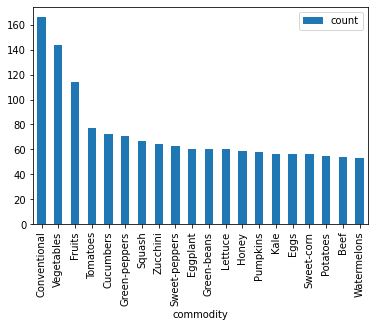

In [138]:
commodity_df.sort_values(by=['count'], ascending = False).head(20).plot(kind = 'bar', x = 'commodity', y = 'count')

In [139]:
np.mean(commodity_df['count'])

8.812977099236642

In [140]:
np.std(commodity_df['count'])

18.221687845278584

{'whiskers': [<matplotlib.lines.Line2D at 0x6885562d60>,
 'caps': [<matplotlib.lines.Line2D at 0x6885571400>,
 'boxes': [<matplotlib.lines.Line2D at 0x6885562a90>],
 'medians': [<matplotlib.lines.Line2D at 0x68855718e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x6885571bb0>],
 'means': []}

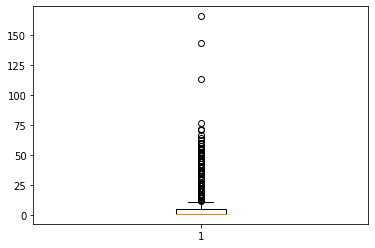

In [141]:
plt.boxplot(commodity_df['count'])

There is a fairly wide spread of commodity counts, discounting the aforementioned top three.